In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
import datetime, os

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


C:\Users\rayde\AppData\Local\Temp\ipykernel_12984\1473605421.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(part[...,0], part[...,1], c=cmap(i/n_partitions/n_partitions) )


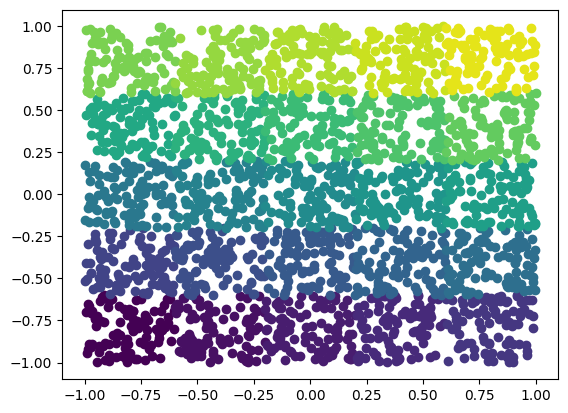

In [153]:
n_samples = 100
n_partitions = 5

random_samples = 2*np.random.rand(n_partitions**2, 2, n_samples)/n_partitions

# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, n_partitions, endpoint=False)
y = np.linspace(-1, 1, n_partitions, endpoint=False)
X,Y = np.meshgrid(x,y)
partitions = random_samples + np.stack([X.flatten(), Y.flatten()]).T[..., np.newaxis]
partitions = np.swapaxes(partitions, 1, 2)

cmap = plt.get_cmap('viridis') 

for i, part  in enumerate(partitions):
    plt.scatter(part[...,0], part[...,1], c=cmap(i/n_partitions/n_partitions) )

In [167]:
# Define vector function with three scalar functions
def f_sum_decomposable(x):
    x1, x2 = x[:,0], x[:,1]
    #use booths funciton, beales function and rosebrock function with a=1 and b=100
    return np.array([8*x1**2 + 4*x2**2 + 3,
            (x1+2*x2-7)**2 + (2*x1+x2-5)**2,
            (1-x1)**2 + 100*(x2-x1**2)**2]).T

[[-1.         -1.        ]
 [-0.97979798 -1.        ]
 [-0.95959596 -1.        ]
 ...
 [ 0.95959596  1.        ]
 [ 0.97979798  1.        ]
 [ 1.          1.        ]]


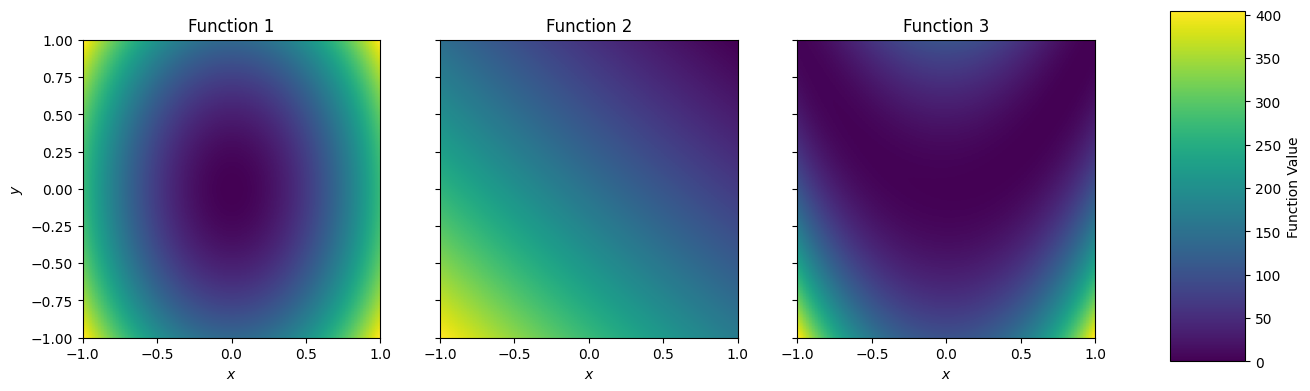

In [182]:
# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(), Y.flatten()]).T

print(coordinates)

f = f_sum_decomposable
# Compute the function values at the grid points for each functions
Z = f(coordinates)
Z = Z.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [183]:
#using pytorch to create the neural network that will be used to approximate the three functions
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# Create the neural network
model = Net().to(device)

# Define the optimizer sgd
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.MSELoss()

# Create a DataLoader object
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
dataset = TensorDataset(coordinates_tensor)
dataloader = DataLoader(dataset, batch_size=100)

# Train the neural network
model.train()
n_epochs = 100
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = data[0].to(device)
        outputs = model(inputs)
        targets = torch.tensor(f(inputs.cpu().numpy()), dtype=torch.float32).to(device)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{n_epochs} Loss: {loss.item()}')




Epoch 0/100 Loss: 589.8095703125
Epoch 10/100 Loss: 690.2505493164062
Epoch 20/100 Loss: 12.478448867797852
Epoch 30/100 Loss: 4.548357963562012
Epoch 40/100 Loss: 7.494002342224121
Epoch 50/100 Loss: 6.4164042472839355
Epoch 60/100 Loss: 4.84174108505249
Epoch 70/100 Loss: 1.5852344036102295
Epoch 80/100 Loss: 1.930928111076355
Epoch 90/100 Loss: 62.441551208496094


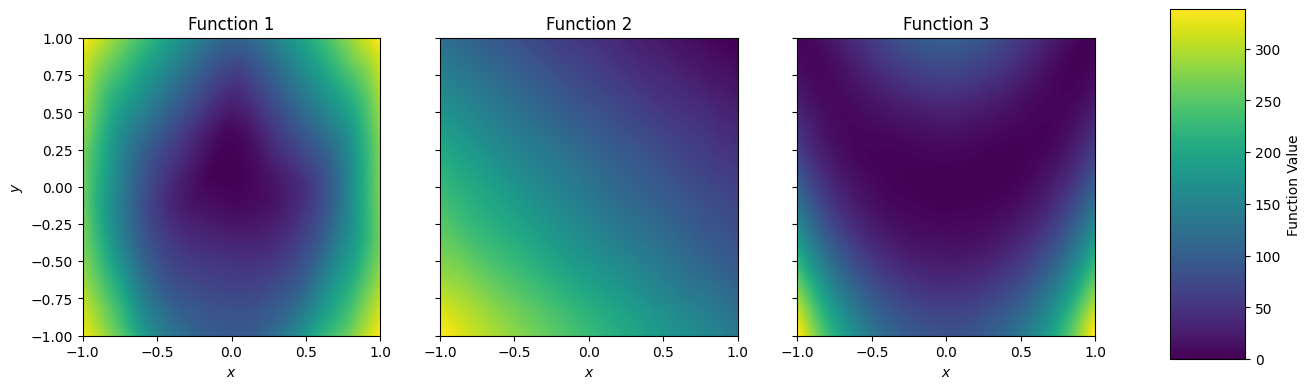

In [184]:
#create some test data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(),
                        Y.flatten()]).T

#make a dataloader
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)

# Evaluate the neural network
model.eval()
outputs = model(coordinates_tensor)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(outputs[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('approximated_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [185]:
#test the model on 10 independent samples, recording the mean mae and mse and the standard deviation of the mae and mse
n_samples = 10
mae = np.zeros(n_samples)
mse = np.zeros(n_samples)
for i in range(n_samples):
    coordinates = np.random.rand(100,2)
    coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
    outputs = model(coordinates_tensor)
    outputs = outputs.cpu().detach().numpy()
    targets = f(coordinates)
    mae[i] = np.mean(np.abs(outputs - targets))
    mse[i] = np.mean((outputs - targets)**2)
print(f'Mean MAE: {np.mean(mae)} +/- {np.std(mae)}')
print(f'Mean MSE: {np.mean(mse)} +/- {np.std(mse)}')


Mean MAE: 1.3210468692938484 +/- 0.04968897439839667
Mean MSE: 3.998677599297924 +/- 0.2822306190546253


[[-1.         -1.        ]
 [-0.97979798 -1.        ]
 [-0.95959596 -1.        ]
 ...
 [ 0.95959596  1.        ]
 [ 0.97979798  1.        ]
 [ 1.          1.        ]]


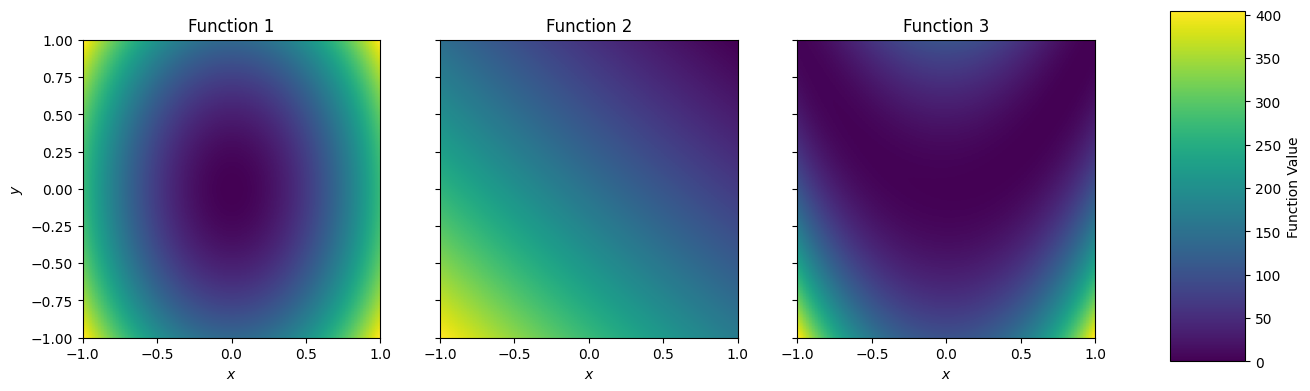

In [172]:
# Create a grid of points in the domain [0, 1]^2
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(), Y.flatten()]).T

print(coordinates)

f = f_sum_decomposable
# Compute the function values at the grid points for each functions
Z = f(coordinates)
Z = Z.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"
titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(Z[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('target_function.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

C:\Users\rayde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


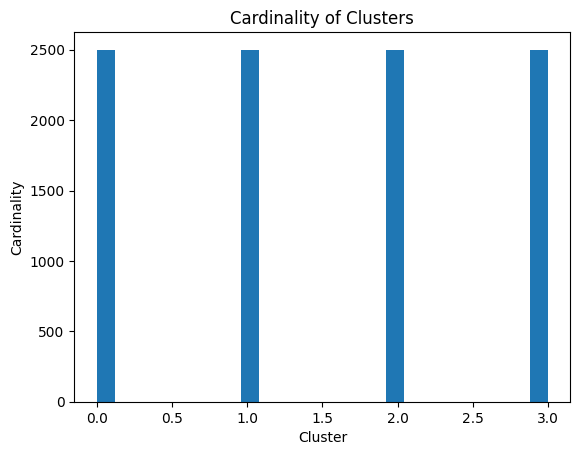

In [173]:
#using kmeans, partition the coordinates into 25 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(coordinates)
clusters = kmeans.labels_

#plot the cardinality of each cluster
plt.hist(clusters, bins=25)
plt.xlabel('Cluster')
plt.ylabel('Cardinality')
plt.title('Cardinality of Clusters')
plt.show()

#make a df containing the coordinates and the cluster they belong to
df = pd.DataFrame(coordinates, columns=['x', 'y'])
df['cluster'] = clusters


In [174]:


#Define the custom optimizer
class COSGD(optim.Optimizer):
    def __init__(self, params, lr):
        defaults = dict(lr=lr)
        super(COSGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                p.data.add_(-group['lr'], d_p)
        
        return loss

def flatten_grads(grads):
    grads = torch.cat([grad.view(-1) for grad in grads])
    return grads

def unflatten_grads(flattened_grads, model):
    grads = []
    start = 0
    for param in model.parameters():
        end = start + param.numel()
        grads.append(flattened_grads[start:end].view(param.size()))
        start = end
    return grads

def sort_grads(grads, sort_order=True):
    avg_abs = [torch.mean(torch.abs(grad)).item() for grad in grads]
    order = sorted(range(len(avg_abs)), key=lambda i: avg_abs[i], reverse=sort_order)
    return order

def unsort_grads(grads, order):
    unsorted_grads = [grads[i] for i in order]
    return unsorted_grads

def orthogonalize_grads(grads):
    flattened_grads = [flatten_grads(cluster_grads) for cluster_grads in grads]

    #sort the vectors by average absolute value in descending order
    order = sort_grads(flattened_grads)
    flattened_grads = [flattened_grads[i] for i in order]

    #now we have a set of vectors, we can perform the gram schmidt process
    ortho_grads = []
    for i, grad in enumerate(flattened_grads):
        for j in range(i):
            #subtract the projection of the current vector onto the previous vectors
            if torch.norm(ortho_grads[j]) != 0:
                grad = grad - (grad @ ortho_grads[j]) / (ortho_grads[j] @ ortho_grads[j]) * ortho_grads[j]
        ortho_grads.append(grad)
    #sort the vectors back to their original order
    ortho_grads = unsort_grads(ortho_grads, order)
    return ortho_grads

In [175]:
#prepare dataloaders for each cluster
#loop size is equal to the min cardinality of a cluster divided by the batch size
max_cardinality = df['cluster'].value_counts().max()
batch_size = 100
num_mini_batches = max_cardinality // batch_size

dataloaders = []
for i in range(4):
    cluster = df[df['cluster'] == i]
    cluster_tensor = torch.tensor(cluster[['x', 'y']].values, dtype=torch.float32).to(device)
    dataset = TensorDataset(cluster_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataloaders.append(dataloader)

def train_model_cosgd(model, optimizer, dataloaders, loss_function, epochs):
    criterion = loss_function
    model.train()

    for epoch in range(epochs):

        clustered_mini_batches = [[] for _ in range(num_mini_batches+1)]
        for dataloader in dataloaders:
            for i, data in enumerate(dataloader):
                clustered_mini_batches[i].append(data[0])

        #print the shape of clustered_mini_batches
        #print([len(mini_batch) for mini_batch in clustered_mini_batches])

        #print the data in each mini batch
        # for i, mini_batch in enumerate(clustered_mini_batches):
        #     print('Mini-Batch set ', i)
        #     for data in mini_batch:
        #         print(len(data))

        #now we have all the relevant data in each mini batch, we need to loop through the mini batches and apply the normal algorithm
        for i, mini_batch in enumerate(clustered_mini_batches):
            grad_updates = []
            optimizer.zero_grad()
            for j, data in enumerate(mini_batch):
                outputs = model(data)
                targets = torch.tensor(f(data.cpu().numpy()), dtype=torch.float32).to(device)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                grad_updates.append([param.grad.data.clone() for param in model.parameters()])
                #print(f'Mini-Batch {i+1}/{len(clustered_mini_batches)}', f'Cluster {j+1}/{len(mini_batch)}', 'Loss :', loss.item())

            if len(grad_updates) == 0:
                continue
            #orthogonalize the gradients
            # print('grad updates before orthogonalization')
            # print(grad_updates)
            grad_updates = orthogonalize_grads(grad_updates)
            # print('grad updates after orthogonalization')
            # print(grad_updates)
            #sum the gradients element wise
            grad_update = torch.sum(torch.stack(grad_updates), dim=0)
            # print('grad update after sum')
            # print(grad_update)
            #unflatten the gradient
            grad_update = unflatten_grads(grad_update, model)
            # print('grad update after unflatten')
            # print(grad_update)
            #set the model parameters to the sum of the gradients
            for param, grad in zip(model.parameters(), grad_update):
                param.grad = grad
            optimizer.step()

        print(f'Epoch {epoch+1}/{epochs}', 'Loss :', loss.item())

                
    return model


In [177]:
# Create the neural network
COSGDmodel = Net().to(device)
#define the optimizer
optimizer = COSGD(COSGDmodel.parameters(), lr=0.001)
#define the loss function
criterion = nn.MSELoss()
# Train the neural network
COSGDmodel = train_model_cosgd(COSGDmodel, optimizer, dataloaders, criterion, 100)


Epoch 1/100 Loss : 1210.1512451171875
Epoch 2/100 Loss : 1087.5628662109375
Epoch 3/100 Loss : 1304.4833984375
Epoch 4/100 Loss : 371.25555419921875
Epoch 5/100 Loss : 1091.887939453125
Epoch 6/100 Loss : 92.22209930419922
Epoch 7/100 Loss : 184.99574279785156
Epoch 8/100 Loss : 139.15736389160156
Epoch 9/100 Loss : 305.3276672363281
Epoch 10/100 Loss : 14.812827110290527
Epoch 11/100 Loss : 24.7642765045166
Epoch 12/100 Loss : 350.2135009765625
Epoch 13/100 Loss : 20.046674728393555
Epoch 14/100 Loss : 57.68418502807617
Epoch 15/100 Loss : 242.7131805419922
Epoch 16/100 Loss : 457.1861877441406
Epoch 17/100 Loss : 97.55579376220703
Epoch 18/100 Loss : 129.86935424804688
Epoch 19/100 Loss : 7.052849292755127
Epoch 20/100 Loss : 7.541316032409668
Epoch 21/100 Loss : 179.88833618164062
Epoch 22/100 Loss : 74.89751434326172
Epoch 23/100 Loss : 315.89227294921875
Epoch 24/100 Loss : 7.3085174560546875
Epoch 25/100 Loss : 7.320188999176025
Epoch 26/100 Loss : 83.10277557373047
Epoch 27/100 

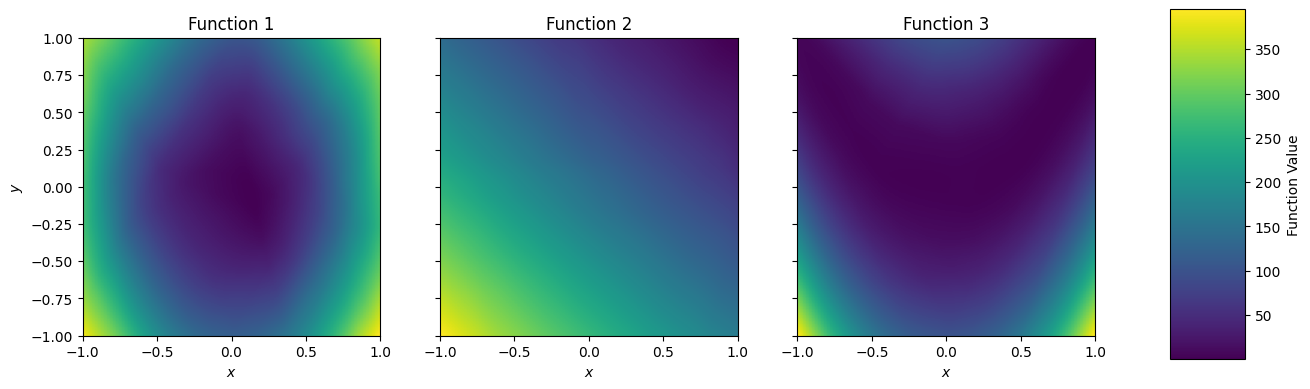

In [178]:
#create some test data
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X,Y = np.meshgrid(x,y)
coordinates = np.stack([X.flatten(),
                        Y.flatten()]).T

#make a dataloader
coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)

# Evaluate the neural network
COSGDmodel.eval()
outputs = COSGDmodel(coordinates_tensor)
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(100,100,3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5), sharey=True)
fig.subplots_adjust(right=0.8)

cmap="viridis"

titles=['Function 1', 'Function 2', 'Function 3']
for idx in range(3):
    im = axs[idx].imshow(outputs[:,:,idx], extent=[-1, 1, -1 ,1], origin='lower', cmap=cmap)
    axs[idx].set_xlabel('$x$')
    axs[idx].set_title(titles[idx])

axs[0].set_ylabel('$y$')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Function Value')

#plt.savefig('approximated_function_cosgd.png', dpi=300, bbox_inches='tight')
#plt.close()
plt.show()

In [179]:
#test the model on 10 independent samples, recording the mean mae and mse and the standard deviation of the mae and mse
n_samples = 10
mae = np.zeros(n_samples)
mse = np.zeros(n_samples)
for i in range(n_samples):
    coordinates = np.random.rand(100,2)
    coordinates_tensor = torch.tensor(coordinates, dtype=torch.float32).to(device)
    outputs = model(coordinates_tensor)
    outputs = outputs.cpu().detach().numpy()
    targets = f(coordinates)
    mae[i] = np.mean(np.abs(outputs - targets))
    mse[i] = np.mean((outputs - targets)**2)
print(f'Mean MAE: {np.mean(mae)} +/- {np.std(mae)}')
print(f'Mean MSE: {np.mean(mse)} +/- {np.std(mse)}')

Mean MAE: 0.7038932594059105 +/- 0.05495905557682472
Mean MSE: 1.5659611530609783 +/- 0.22856097396719477
